In [1]:
from tensorflow import keras
from keras.datasets import cifar10
import os
import time
import numpy as np
# Library for plot the output and save to file                                  
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import time

import math
from pycuda import gpuarray
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

%matplotlib inline


In [2]:



baseDir = os.path.dirname(os.path.abspath('__file__')) + '/'
classesName = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()
xVal = xTrain[49000:, :].astype(np.float)
yVal = np.squeeze(yTrain[49000:, :])
xTrain = xTrain[:49000, :].astype(np.float)
yTrain = np.squeeze(yTrain[:49000, :])
yTest = np.squeeze(yTest)
xTest = xTest.astype(np.float)



# Pre processing data                                                           
# Normalize the data by subtract the mean image                                 
meanImage = np.mean(xTrain, axis=0)
xTrain -= meanImage
xVal -= meanImage
xTest -= meanImage

# Reshape data from channel to rows                                             
xTrain = np.reshape(xTrain, (xTrain.shape[0], -1))
xVal = np.reshape(xVal, (xVal.shape[0], -1))
xTest = np.reshape(xTest, (xTest.shape[0], -1))
# Add bias dimension columns                                                    
xTrain = np.hstack([xTrain, np.ones((xTrain.shape[0], 1))])
xVal = np.hstack([xVal, np.ones((xVal.shape[0], 1))])
xTest = np.hstack([xTest, np.ones((xTest.shape[0], 1))])


class Svm (object):
    """" Svm classifier """

    def __init__ (self, inputDim, outputDim):
        self.W = None
        sigma =0.01
        self.W = sigma * np.random.randn(inputDim,outputDim)
        self.s_dummy = np.zeros((200,10)).astype(np.float32)
        self.time1=0
        self.time2=0
        self.time3=0
        self.time4=0
        self.time5=0
        self.time6=0
        self.time7=0
        self.time8=0
        self.final_time=0

    def calLoss (self, x, y, reg): # x is a 2D array. num of rows is the num of examples


        ### 1st kerel #############################
        dW = np.zeros_like(self.W).astype(np.float32)

        # tiled-version of dot product of x and w
        # we have too kernels ready, x_dot_w.cu and x_dot_w_tile.cu
        
        prg_sgd1 = SourceModule(open("../kernels/x_dot_w_tile.cu", "r").read())
        func1 = prg_sgd1.get_function("x_dot_w")
        
        batchSize = x.shape[0]
        featureSize = x.shape[1]
        
        dim0 = 10
        dim1 = 10
        block_dim = (dim0, dim1, 1)
        grid_dim = (1, math.ceil(x.shape[0]/dim1), 1)

        d_x = gpuarray.to_gpu(x.astype(np.float32))
        d_w = gpuarray.to_gpu(self.W.astype(np.float32))
        d_s = gpuarray.empty(self.s_dummy.shape ,dtype=np.float32)
        a_start = cuda.Event()
        a_end = cuda.Event()
        a_start.record()
        func1( d_x , d_w , d_s,
                np.int32(batchSize),
                np.int32(featureSize),
                np.int32(10),
                block=block_dim,
                grid=grid_dim)
        
        a_end.record()
        a_end.synchronize()
        # time1 is the execution of the 1st kernel.
        self.time1= a_start.time_till(a_end) *(1e-3)
        s = d_s.get()
        a_s = time.time()
        

        s_yi = s[np.arange(x.shape[0]),y]
        ae = time.time()
        # time2 is to calculate s_yi
        self.time2= ae- a_s



        #####  2nd kernel ############################
        ## not using max_epoch ###
        prg_sgd2 = SourceModule(open("../kernels/delta.cu", "r").read())
        func2 = prg_sgd2.get_function("delta")
        dimd0 = 10
        dimd1 = 10
        batchSize = x.shape[0]
        block_dimd = (dimd0, dimd1, 1)
        grid_dimd = (1, math.ceil(x.shape[0]/dimd1), 1)
        d_s =  gpuarray.to_gpu(s.astype(np.float32))
        d_y =  gpuarray.to_gpu(s_yi.astype(np.float32))
        d_delta = gpuarray.empty(s.shape ,dtype=np.float32)
        
        b_start = cuda.Event()
        b_end =cuda.Event()
        b_start.record()
        func2( d_s , d_y , d_delta,
                np.int32(batchSize),
                np.int32(10),
                block=block_dimd,
               grid=grid_dimd)
        b_end.record()
        b_end.synchronize()
        # time3 is the execution time of 2nd kernel
        self.time3= b_start.time_till(b_end)*(1e-3)

        delta = d_delta.get()
        ds = np.zeros_like(delta)
        
        ####   3rd kernel  #############################
        # not using max_epochs #
        prg_sgd3 = SourceModule(open("../kernels/ds.cu", "r").read())
        func3 = prg_sgd3.get_function("ds")

        d_ds =  gpuarray.to_gpu(ds.astype(np.float32))
        d_y =  gpuarray.to_gpu(y.astype(np.int32))
        d_delta = gpuarray.to_gpu(delta.astype(np.float32))

        c_start =cuda.Event()
        c_end = cuda.Event()
        c_start.record()
        func3( d_ds , d_y , d_delta,
                   np.int32(batchSize),
                   np.int32(10),
                   block=block_dimd,
                   grid=grid_dimd)
        c_end.record()
        c_end.synchronize()
        # time5 is the execution time of the 3rd kernel
        self.time5= c_start.time_till(c_end)*(1e-3)        
        ds = d_ds.get()

        c_s =time.time()
        ds[np.arange(x.shape[0]),y] = -np.sum(ds, axis=1)
        c_e = time.time()
        # time6 is to calculate ds[] 
        self.time6= c_e - c_s


        ### 4th kernel  ####################
        # not using max_epoch
        prg_sgd6 = SourceModule(open("../kernels/xT.cu", "r").read())

        dim00 = 32
        dim11= 32

        block_dim2 = (dim00, dim11, 1)
        grid_dim2 = (math.ceil(x.shape[0]/dim00), math.ceil(x.shape[1]/dim11) , 1)

        func6 = prg_sgd6.get_function("xT")
        d_xp  = gpuarray.to_gpu(x.astype(np.float32))
        d_XT  = gpuarray.empty((3073,200), dtype=np.float32 )
        d_start =cuda.Event()
        d_end= cuda.Event()
        d_start.record()
        func6( d_xp, d_XT, 
               np.int32(batchSize),
               np.int32(featureSize),
               block=block_dim2,  grid=grid_dim2)
        d_end.record()
        d_end.synchronize()
        # time4 is for the execution time for the 4th kernel
        self.time4= d_start.time_till(d_end)*(1e-3)


        #####   5th kernel #################################
        ## have 2 versions of kernel, get_w_combo.cu and get_w_combo_tiled.cu 
        prg_sgd5 = SourceModule(open("../kernels/get_w_combo_tiled.cu", "r").read())
        dim00 =10
        dim11= 10
        block_dim2 = (dim00, dim11, 1)
        grid_dim2 = (math.ceil(dW.shape[1]/dim00), math.ceil(dW.shape[0]/dim11) , 1)
        
        func5 = prg_sgd5.get_function("get_w_combo")
        
        d_xp  = gpuarray.to_gpu(d_XT.get().astype(np.float32))
        d_DS  = gpuarray.to_gpu(ds.astype(np.float32))
        d_W = gpuarray.to_gpu(self.W.astype(np.float32))
        
        d_start =cuda.Event()
        d_end= cuda.Event()
        d_start.record()
        
        func5( d_xp, d_DS, d_W,
               np.int32(featureSize),
               np.int32(batchSize),
               np.int32(10),
               block=block_dim2,  grid=grid_dim2)
        
        d_end.record()
        d_end.synchronize()
        ## time7 is for the 5th kernel.
        self.time7= d_start.time_till(d_end)*(1e-3)
        

        # total time for execution.
        self.final_time+= self.time1 + self.time2 + self.time3 + self.time4 +self.time5 +self.time6 +self.time7 
        self.W = d_W.get()
        return self.W 
  
    def train (self, x, y, lr=1e-3, reg=1e-5, iter=100, batchSize=200, verbose=False):
        # Run stochastic gradient descent to optimize W. 
        lossHistory = []
        for i in range(iter):
            xBatch = None
            yBatch = None
            # draw num_train samples from x, num_train is a 1-D array contains integeres
            num_train = np.random.choice(x.shape[0], batchSize)
            xBatch = x[num_train] # xBatch is a 2D array, each row is a data point,
            yBatch = y[num_train]
            w_g  = self.calLoss(xBatch,yBatch,reg)

        print(" EXE time" , self.final_time)
        return self.final_time
    
    
    def predict (self, x,):
        yPred = np.zeros(x.shape[0])
        s = x.dot(self.W)
        yPred = np.argmax(s, axis=1)
        return yPred
    
    def calAccuracy (self, x, y):
        acc = 0
        yPred = self.predict(x)
        acc = np.mean(y == yPred)*100
        return acc



classifier_0 is used to run once for max_epoch = 500

In [3]:
numClasses = np.max(yTrain) + 1
classifier = Svm(xTrain.shape[1], numClasses)
# Training classifier
startTime = time.time()

classifier.train(xTrain, yTrain, lr=1e-7, reg=5e4, iter=500 ,verbose=True)

print ('Training time: {0}'.format(time.time() - startTime))
print ('Training acc:   {0}%'.format(classifier.calAccuracy(xTrain, yTrain)))
print ('Validating acc: {0}%'.format(classifier.calAccuracy(xVal, yVal)))
print ('Testing acc:    {0}%'.format(classifier.calAccuracy(xTest, yTest)))

 EXE time 0.3390140952207145
Training time: 8.43691611289978
Training acc:   35.45918367346938%
Validating acc: 36.199999999999996%
Testing acc:    34.8%


we declare a new classifer for each different max_epoch
THe following code section is used to collect time result for different max_epochs

In [4]:
# Training classifier


t = []
acc_tr = []
acc_te = []
#loss_a = []

itr = 50
for i in range(itr):
    max_iter = (i+1) * 10
    classifier = Svm(xTrain.shape[1], numClasses)
    final_time = classifier.train(xTrain, yTrain,
                          lr=1e-7,
                          reg=5e4,
                          iter=max_iter,
                          verbose=True)
    #endTime = time.time()
    
    t.append(final_time)
    acc_tr.append(classifier.calAccuracy(xTrain, yTrain))
    acc_te.append(classifier.calAccuracy(xTest, yTest))



 EXE time 0.006891787204891443
 EXE time 0.014302699036896233
 EXE time 0.020633773278445015
 EXE time 0.028319296877831218
 EXE time 0.03483403825759888
 EXE time 0.04085808002576231
 EXE time 0.0471644304022193
 EXE time 0.054144133653491716
 EXE time 0.061778386507183314
 EXE time 0.06694037246704101
 EXE time 0.07453686989843844
 EXE time 0.07924699755385525
 EXE time 0.08674552319198846
 EXE time 0.09285317160561678
 EXE time 0.09994233169406656
 EXE time 0.10411486090347166
 EXE time 0.11121362013742332
 EXE time 0.11834971013665196
 EXE time 0.1250806107223034
 EXE time 0.13126611831039187
 EXE time 0.13377225665003062
 EXE time 0.13800559499114762
 EXE time 0.14639244251325717
 EXE time 0.15238949550688272
 EXE time 0.16367373342067013
 EXE time 0.15869272061809905
 EXE time 0.17473111975193037
 EXE time 0.17187459057942034
 EXE time 0.18195936220511788
 EXE time 0.18715766214951884
 EXE time 0.1919116314947605
 EXE time 0.19907615602761508
 EXE time 0.20881008082255728
 EXE ti

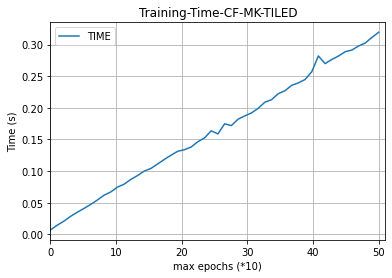

In [7]:
### print time with max_epochs ####
x0 = np.linspace(0, itr, itr)
fig0, ax0 = plt.subplots()
line1, = ax0.plot(x0, t, label='TIME')
ax0.set_title('Training-Time-CF-MK-TILED')
ax0.set_xlabel('max epochs (*10)')
ax0.set_ylabel('Time (s)')
#ax0.set_yscale('log')
ax0.grid(True)
ax0.set_xlim(0, itr + 1)
ax0.xaxis.set_ticks(np.arange(0,itr + 1, 10))
ax0.legend()
plt.savefig("../result-plots/CF-MK-TILED-Time.png")

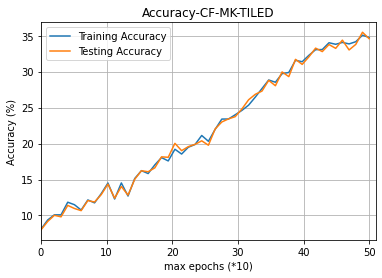

In [12]:
### print accuracy on test and train with max_epochs ###

x1 = np.linspace(0, itr, itr)
fig1, ax1 = plt.subplots()
line1, = ax1.plot(x1, acc_tr, label='Training Accuracy')
line1, = ax1.plot(x1, acc_te, label='Testing Accuracy')
ax1.set_title('Accuracy-CF-MK-TILED')
ax1.set_xlabel('max epochs (*10)')
ax1.set_ylabel('Accuracy (%)')

ax1.grid(True)
ax1.set_xlim(0, itr + 1)
ax1.xaxis.set_ticks(np.arange(0,itr + 1, 10))
ax1.legend()
plt.savefig("../result-plots/CF-MK-TILED-Accuracy.png")

In [9]:
acc_tr

[8.075510204081633,
 9.36530612244898,
 10.087755102040816,
 10.087755102040816,
 11.840816326530613,
 11.495918367346938,
 10.753061224489796,
 12.157142857142857,
 11.753061224489796,
 13.038775510204081,
 14.512244897959183,
 12.287755102040816,
 14.524489795918367,
 12.702040816326532,
 15.134693877551019,
 16.23265306122449,
 15.828571428571427,
 17.036734693877552,
 18.048979591836734,
 17.583673469387755,
 19.208163265306123,
 18.540816326530614,
 19.487755102040815,
 19.86734693877551,
 21.122448979591837,
 20.314285714285717,
 21.96938775510204,
 23.40408163265306,
 23.414285714285715,
 24.00408163265306,
 24.612244897959183,
 25.342857142857145,
 26.46122448979592,
 27.653061224489793,
 28.838775510204083,
 28.528571428571432,
 29.718367346938773,
 29.883673469387755,
 31.579591836734693,
 31.379591836734694,
 32.27142857142857,
 33.05714285714286,
 33.0734693877551,
 34.02040816326531,
 33.80408163265306,
 34.06530612244898,
 33.85714285714286,
 34.16326530612245,
 35.073469

In [10]:
acc_te

[7.99,
 9.16,
 10.02,
 9.81,
 11.4,
 10.97,
 10.67,
 12.07,
 11.87,
 12.9,
 14.360000000000001,
 12.4,
 14.030000000000001,
 12.83,
 15.040000000000001,
 16.220000000000002,
 16.08,
 16.619999999999997,
 18.15,
 18.09,
 20.03,
 19.009999999999998,
 19.57,
 19.89,
 20.380000000000003,
 19.77,
 22.02,
 23.0,
 23.43,
 23.74,
 24.81,
 26.090000000000003,
 26.85,
 27.3,
 28.79,
 28.04,
 29.959999999999997,
 29.310000000000002,
 31.71,
 31.009999999999998,
 32.06,
 33.269999999999996,
 32.79,
 33.77,
 33.239999999999995,
 34.38,
 33.019999999999996,
 33.79,
 35.480000000000004,
 34.58]

In [11]:
t

[0.006891787204891443,
 0.014302699036896233,
 0.020633773278445015,
 0.028319296877831218,
 0.03483403825759888,
 0.04085808002576231,
 0.0471644304022193,
 0.054144133653491716,
 0.061778386507183314,
 0.06694037246704101,
 0.07453686989843844,
 0.07924699755385525,
 0.08674552319198846,
 0.09285317160561678,
 0.09994233169406656,
 0.10411486090347166,
 0.11121362013742332,
 0.11834971013665196,
 0.1250806107223034,
 0.13126611831039187,
 0.13377225665003062,
 0.13800559499114762,
 0.14639244251325717,
 0.15238949550688272,
 0.16367373342067013,
 0.15869272061809905,
 0.17473111975193037,
 0.17187459057942034,
 0.18195936220511788,
 0.18715766214951884,
 0.1919116314947605,
 0.19907615602761508,
 0.20881008082255728,
 0.2128217911943794,
 0.2222858499549329,
 0.22693633919209238,
 0.2354940271340312,
 0.2394212420955302,
 0.24465577683970352,
 0.2568948554173111,
 0.2819859591759741,
 0.2699239136353135,
 0.2764572837166486,
 0.28190614093467603,
 0.28871789183095087,
 0.291404325321